# Predict Animation Movies' Revenues

### Scrape from IMDB

In [2]:
from __future__ import print_function, division

In [3]:
# Import packages

import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pprint import pprint
import pandas as pd
import collections
import matplotlib.pyplot as plt
import re
from datetime import datetime
import pickle
import sklearn
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn import linear_model, preprocessing
import patsy
import statsmodels.api as sm
import os,sys
from scipy import stats

import seaborn as sns

import pandas as pd

%matplotlib inline

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
# Sample Url

sample_url = 'http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page={}&ref_=adv_prv'

In [6]:
# Convert links from tag to list

def imdb_find_all_links(url):
    link_list = []
    response = requests.get(url)
    response.status_code
    page = response.text
    soup = BeautifulSoup(page,"lxml")
    for link in soup.find_all('a'): 
        link_list.append(str(link))
    return link_list

In [7]:
# Extract 50 movie links from each page

def imdb_find_movie_link(url):
    title_list = []
    for link in imdb_find_all_links(url):
        if link.find('a href="/title/') != -1 and link.find('vote') == -1 and link.find('plot') == -1:    
            start = link.find('a href="/title/')
            end = link.find('?',start+1)
            title = (link[start+8:end])
            title = 'http://www.imdb.com' + title
            if title not in title_list:
                title_list.append(title)
        else:
            continue
    return title_list

In [8]:
# Add movie title

def movie_title(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('title').string)

In [9]:
# Explore movie rating

def movie_rating(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('span', class_ = "rating"))

In [10]:
# Explore movie MPAA

def movie_mpaa(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('meta', itemprop = "contentRating"))[15:17]

In [11]:
# Explore awards

def movie_awards(url_base):
    temp = []
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    test = soup.findAll('span', itemprop = "awards")
    for sublist in test:
        temp.append(sublist.getText().replace('\n', '').replace('   ',''))
    return str(temp)

In [12]:
# Explore the 'Details' section
# Extract info about budget, country, gross, language, production co, release date, runtime

def movie_details(url_base):
    # Read Url
    html = urlopen(url_base)
    # Create Soup
    soup = BeautifulSoup(html, 'lxml')
    test = soup.findAll('div',class_='txt-block')
    temp = []
    for sublist in test:
        for phrase in sublist.findAll('h4',class_='inline'):
            label = phrase.getText().replace(':','')
            text = phrase.nextSibling
            if len(text.strip()) == 0:
                next_text = text.nextSibling.getText().strip()
                temp.append((label,next_text))
            else:
                text = text.replace('        \n\n      ','')
                text = text.replace('(USA)','')
                temp.append((label, text.strip()))

    # Convert List of Tuples to Dictionary
    temp = dict(temp)
    return temp

In [13]:
def compile_data_info(x):
    new_df = pd.DataFrame()
    for link in imdb_find_movie_link(x):
        data = pd.DataFrame.from_dict(movie_details(link),orient='index', dtype=None)
        data = data.transpose()
        data['Movie Title'] = movie_title(link)
        data['Rating Score'] = movie_rating(link)
        data['MPAA'] = movie_mpaa(link)
        data['Awards'] = movie_awards(link)
        new_df = new_df.append(data)
    return new_df

#### Render pages into dataframes

In [14]:
imdb_page_1 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=1&ref_=adv_prv')

KeyboardInterrupt: 

In [15]:
imdb_page_2 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=2&ref_=adv_prv')

KeyboardInterrupt: 

In [16]:
imdb_page_3 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=3&ref_=adv_prv')

KeyboardInterrupt: 

In [17]:
imdb_page_4 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=4&ref_=adv_prv')

KeyboardInterrupt: 

In [18]:
imdb_page_5 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=5&ref_=adv_prv')

KeyboardInterrupt: 

In [ ]:
imdb_page_6 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=6&ref_=adv_prv')

KeyboardInterrupt: 

In [ ]:
imdb_page_7 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=7&ref_=adv_prv')

In [ ]:
imdb_page_8 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=8&ref_=adv_prv')

In [ ]:
# Combine 6 dataframes into 1

movies_data_2 = pd.DataFrame()
movies_data_2 = movies_data_2.append(imdb_page_1)
movies_data_2 = movies_data_2.append(imdb_page_2)
movies_data_2 = movies_data_2.append(imdb_page_3)
movies_data_2 = movies_data_2.append(imdb_page_4)
movies_data_2 = movies_data_2.append(imdb_page_5)
movies_data_2 = movies_data_2.append(imdb_page_6)
movies_data_2 = movies_data_2.append(imdb_page_7)
movies_data_2 = movies_data_2.append(imdb_page_8)

In [ ]:
movies_data_2

In [ ]:
# Numer of data points

len(movies_data_2)

In [ ]:
# Save the data frame into a pickle file

with open('my_data_3.pkl', 'wb') as picklefile:
    pickle.dump(movies_data_2, picklefile)

In [ ]:
# Load pickle file

with open('my_data_3.pkl', 'rb') as picklefile: 
    my_old_data = pickle.load(picklefile)

In [ ]:
new_df = pd.read_pickle('my_data_3.pkl')

### Process the Data

In [ ]:
# Make a copy of movies_data

imdb_data = movies_data_2

In [ ]:
# Display dataframe info

imdb_data.info()

In [ ]:
# Drop data points outside of USA

imdb_data = imdb_data[imdb_data['Country'] == 'USA']

In [ ]:
# Drop data points with no rating values

imdb_data = imdb_data[imdb_data['Rating Score'] != 'None']

In [ ]:
len(imdb_data)

In [ ]:
# Remove contents in parenthesis for release date

for n in range(len(imdb_data['Release Date'])):
    if imdb_data['Release Date'].iloc[n].find('(') != -1:
        position = imdb_data['Release Date'].iloc[n].find('(')
        imdb_data['Release Date'].iloc[n] = imdb_data['Release Date'].iloc[n][:position]
    else:
        continue

In [ ]:
# Convert release date to date object and extract year, month and day

imdb_data['Release Date'] = pd.to_datetime(imdb_data['Release Date'])
imdb_data['Release Year'] =imdb_data['Release Date'].dt.year
imdb_data['Release Month'] = imdb_data['Release Date'].dt.month
imdb_data['Release Day'] = imdb_data['Release Date'].dt.day

In [ ]:
# Add ordinal of the release dates

imdb_data['Release Date Ordinal'] = imdb_data['Release Date'].apply(lambda x: x.toordinal())

In [ ]:
# Add day of the week for release date

imdb_data['Release Date Ordinal'] = imdb_data['Release Date'].apply(lambda x: x.toordinal())

In [ ]:
# Remove contents in brackets for rating score

for n in range(len(imdb_data['Rating Score'])):
    if imdb_data['Rating Score'].iloc[n].find('>') != -1:
        start = imdb_data['Rating Score'].iloc[n].find('>')
        end = imdb_data['Rating Score'].iloc[n].find('<', start+1)
        imdb_data['Rating Score'].iloc[n] = imdb_data['Rating Score'].iloc[n][start+1:end]
    else:
        continue

In [ ]:
# Remove contents in parenthesis for opening weekend

for n in range(len(imdb_data['Opening Weekend'])):
    if str(imdb_data['Opening Weekend'].iloc[n]).find('(') != -1:
        position = str(imdb_data['Opening Weekend'].iloc[n]).find('(')
        imdb_data['Opening Weekend'].iloc[n] = str(imdb_data['Opening Weekend'].iloc[n])[:position]
    else:
        continue

In [ ]:
# Convert data types
# RUN ONLY ONCE!

imdb_data['Budget'] = imdb_data['Budget'].replace('[\$,]', '', regex=True).astype(float)
imdb_data['Gross'] = imdb_data['Gross'].replace('[\$,]', '', regex=True).astype(float)
imdb_data['Runtime'] = imdb_data['Runtime'].replace('min', '', regex=True).astype(float)
imdb_data['Rating Score'] = imdb_data['Rating Score'].replace('<span class="rating">7.9<span class="ofTen">', '7.9').apply(lambda x: float(x.split('/')[0]))
imdb_data['Opening Weekend'] = imdb_data['Opening Weekend'].replace('[\$,]', '', regex=True).replace('UK', '', regex=True).replace('[\£,]', '', regex=True).astype(float)

In [ ]:
# Remove contents in parenthesis for movie title

for n in range(len(imdb_data['Movie Title'])):
    if imdb_data['Movie Title'].iloc[n].find('(') != -1:
        position = imdb_data['Movie Title'].iloc[n].find('(')
        imdb_data['Movie Title'].iloc[n] = imdb_data['Movie Title'].iloc[n][:position]
    else:
        continue

In [ ]:
# Drop data points with release date before 1980 (10 of them)

imdb_data = imdb_data[imdb_data['Release Year'] > 1980]

In [ ]:
# Drop data points with no MPAA info (2 of them)

imdb_data = imdb_data[imdb_data['MPAA'] != 'NO']

In [ ]:
imdb_data.info()

In [ ]:
imdb_data.head()

#### Process Categorical Data

In [ ]:
# Group months into quarters

import datetime as dt

imdb_data['Release Date Quarter'] = imdb_data['Release Date'].dt.quarter

In [ ]:
# Add day of the week for release date

imdb_data['Release Date DOW'] = imdb_data['Release Date'].dt.dayofweek

In [ ]:
# Add awards results

imdb_data['Awards Result'] = 'Not'
imdb_data.loc[imdb_data['Awards'].str.contains('Won'), 'Awards Result'] = 'Won'
imdb_data.loc[imdb_data['Awards'].str.contains('Nominated'), 'Awards Result'] = 'Nominated'

In [ ]:
# FIX
# Group productions cos into large, medium and small based on gross 

Large_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[0:10]
Medium_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[10:21]
Small_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[21:]

In [ ]:
# TRY THIS LATER
imdb_data.loc[str(imdb_data['Production Co']) in Large_Cos, 'Production Co Size'] = 'Large'
imdb_data.loc[str(imdb_data['Production Co']) in Medium_Cos, 'Production Co Size'] = 'Medium'
imdb_data.loc[str(imdb_data['Production Co']) in Small_Cos, 'Production Co Size'] = 'Small'

In [ ]:
imdb_data['Production Co Size'] = imdb_data['Production Co'].apply(lambda x: 'Large' if str(x) in Large_Cos)

In [ ]:
def co_size(data):
    for n in range(len(data)):
        if data.iloc[n].loc['Production Co'] in Large_Cos:
            data.iloc[n].loc['Production Co Size'] = 'Large'
        elif data.iloc[n]['Production Co'] in Medium_Cos:
            data.iloc[n].loc['Production Co Size'] = 'Medium'
        else:
            data.iloc[n].loc['Production Co Size'] = 'Small'

In [ ]:
# Replace missing values with medians or modes

# Fill in budget (27 missing)
# Fill in opening weekend (30 missing)
# Fill in runtime (29 missing)

imdb_data = imdb_data.fillna(imdb_data.median())


In [ ]:
imdb_data.info()

### Exploratory Data Analysis

In [ ]:
# Budget vs Gross Scatterplot

plt.figure(figsize=(10,8))
plt.scatter(imdb_data['Budget'], imdb_data['Gross'])
plt.xlabel('Budget')
plt.ylabel('Domestic Total Gross')
plt.title('Budget vs Domestic Total Gross')

In [ ]:
# Rating vs Gross Scatterplot

plt.figure(figsize=(10,8))
plt.scatter(imdb_data['Rating Score'], imdb_data['Gross'])
plt.xlabel('Rating Score')
plt.ylabel('Domestic Total Gross')
plt.title('Rating Score vs Domestic Total Gross')

In [ ]:
# Gross revenues over time

plt.figure(figsize =(10,8))
plt.plot_date(imdb_data['Release Date'], imdb_data['Gross'])

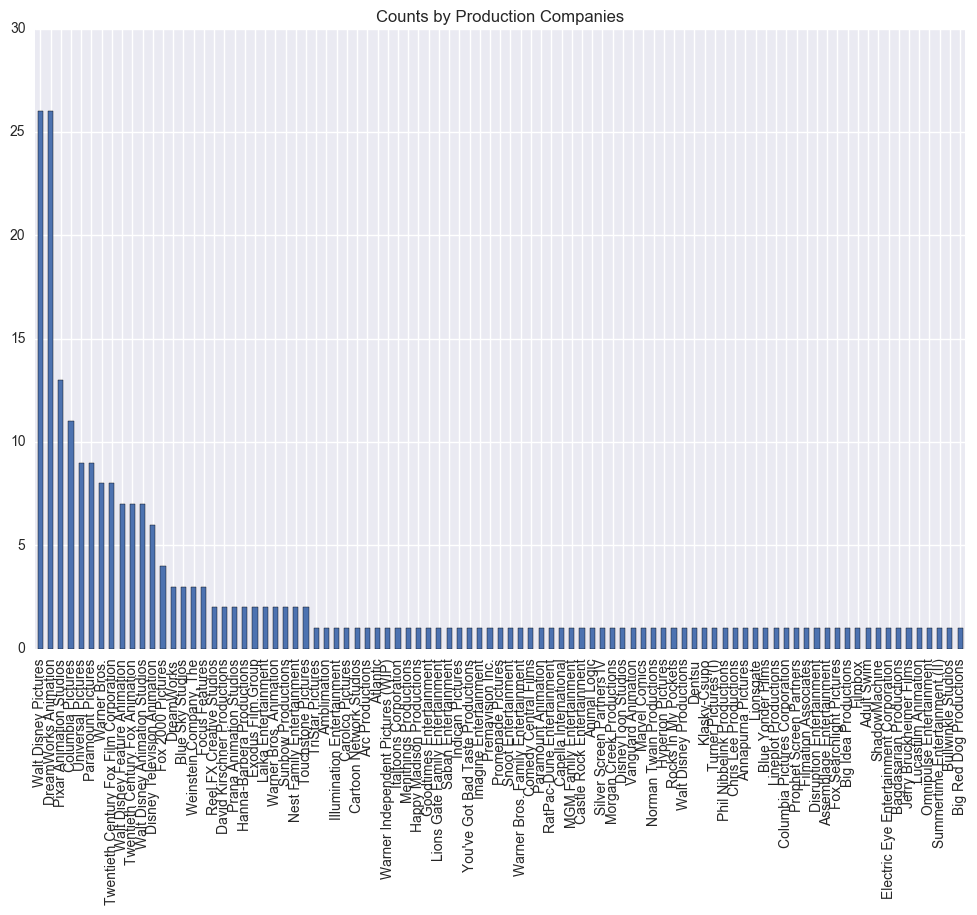

In [94]:
# Bar plots of production co counts

plt.figure(figsize=(12,8))
imdb_data['Production Co'].value_counts().plot(kind='bar')
plt.title('Counts by Production Companies')

### Linear Regression

#### First Model

In [117]:
# Make a copy of imdb_data for modeling

dfm = imdb_data

In [148]:
dfm.columns

Index(['Also Known As', 'Aspect Ratio', 'Awards', 'Budget', 'Certificate',
       'Color', 'Country', 'Filming Locations', 'Gross', 'Language', 'MPAA',
       'Movie Title', 'Official Sites', 'OpeningWeekend', 'Parents Guide',
       'ProductionCo', 'RatingScore', 'Release Date', 'Runtime', 'Sound Mix',
       'Taglines', 'Release Year', 'Release Month', 'Release Day',
       'ReleaseDateOrdinal', 'Release Date Quarter', 'Release Date DOW',
       'Awards Result'],
      dtype='object')

In [160]:
# Drop variables irrelevant to model

#dfm = dfm.drop('Also Known As', 1)
#dfm = dfm.drop('Aspect Ratio', 1)
#dfm = dfm.drop('Awards', 1)
#dfm = dfm.drop('Certificate', 1)
#dfm = dfm.drop('Movie Title', 1)
#dfm = dfm.drop('Official Sites', 1)
#dfm = dfm.drop('Sound Mix', 1)
#dfm = dfm.drop('Taglines', 1)
#dfm = dfm.drop('Filming Locations', 1)
#dfm = dfm.drop('Color', 1)
#dfm = dfm.drop('Country', 1)
#dfm = dfm.drop('Language', 1)
#dfm = dfm.drop('Parents Guide', 1)

In [1]:
dfm.info()

NameError: name 'dfm' is not defined

In [135]:
# Create dummy variables for MPAA

MPAADummies = pd.get_dummies(dfm['MPAA'])
MPAADummies.head()

,,"G""",PG,"R""",UN
0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0


In [136]:
# Create dummy variables for awards results

AwardsResultsDummies = pd.get_dummies(dfm['Awards Result'])
AwardsResultsDummies.head()

,Nominated,Not,Won
0,1.0,0.0,0.0
0,1.0,0.0,0.0
0,0.0,0.0,1.0
0,0.0,0.0,1.0
0,0.0,0.0,1.0


In [131]:
# Create dummy variables for release year

ReleaseYearDummies = pd.get_dummies(dfm['Release Year'])
ReleaseYearDummies.head()

,1981,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [240]:
# Create dummy variables for release month

ReleaseMonthDummies = pd.get_dummies(dfm['Release Month'])
ReleaseMonthDummies.columns = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12']
ReleaseMonthDummies.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [243]:
# Create dummy variables for day of the week

ReleaseDOWDummies = pd.get_dummies(dfm['Release Date DOW'])
ReleaseDOWDummies.columns = ['Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
ReleaseDOWDummies.head()

,Tues,Wed,Thur,Fri,Sat,Sun
0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0,0.0,0.0


In [250]:
# Create dummy variables for release date quarter

ReleaseQuarterDummies = pd.get_dummies(dfm['Release Date Quarter'])
ReleaseQuarterDummies.columns = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4']
ReleaseQuarterDummies.head()

,Quarter1,Quarter2,Quarter3,Quarter4
0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0
0,0.0,0.0,0.0,1.0


In [251]:
# Append dummy variables 
dfm_d = dfm.append(MPAADummies)
dfm_d = dfm.append(AwardsResultsDummies)
dfm_d = dfm.append(ReleaseYearDummies)
dfm_d = dfm.append(ReleaseMonthDummies)
dfm_d = dfm.append(ReleaseDOWDummies)
dfm_d = dfm.append(ReleaseQuarterDummies)

dfm_d.head()

//anaconda/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


,Awards Result,Budget,Gross,MPAA,OpeningWeekend,ProductionCo,Quarter1,Quarter2,Quarter3,Quarter4,RatingScore,Release Date,Release Date DOW,Release Date Quarter,Release Day,Release Month,Release Year,ReleaseDateOrdinal,Runtime
0,Nominated,200000000.0,486292984.0,PG,135060273.0,Pixar Animation Studios,NaN,NaN,NaN,NaN,7.5,2016-06-17,4.0,2.0,17.0,6.0,2016.0,736132.0,97.0
0,Nominated,150000000.0,436471036.0,PG,108037878.0,DreamWorks,NaN,NaN,NaN,NaN,7.2,2004-05-19,2.0,2.0,19.0,5.0,2004.0,731720.0,93.0
0,Won,45000000.0,422783777.0,"G""",16650343.0,Walt Disney Pictures,NaN,NaN,NaN,NaN,8.5,1994-06-24,4.0,2.0,24.0,6.0,1994.0,728103.0,88.0
0,Won,200000000.0,414984497.0,"G""",109000000.0,Walt Disney Pictures,NaN,NaN,NaN,NaN,8.3,2010-06-18,4.0,2.0,18.0,6.0,2010.0,733941.0,103.0
0,Won,150000000.0,400736600.0,PG,67391326.0,Walt Disney Animation Studios,NaN,NaN,NaN,NaN,7.5,2013-11-27,2.0,4.0,27.0,11.0,2013.0,735199.0,102.0


In [179]:
dfm_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 0
Data columns (total 14 columns):
Budget                  211 non-null float64
Gross                   238 non-null float64
MPAA                    239 non-null object
OpeningWeekend          208 non-null float64
ProductionCo            237 non-null object
RatingScore             239 non-null float64
Release Date            239 non-null datetime64[ns]
Runtime                 209 non-null float64
Release Month           239 non-null int64
Release Day             239 non-null int64
ReleaseDateOrdinal      239 non-null int64
Release Date Quarter    239 non-null int64
Release Date DOW        239 non-null int64
Awards Result           239 non-null object
dtypes: datetime64[ns](1), float64(5), int64(5), object(3)
memory usage: 28.0+ KB


In [184]:
dfm

,Budget,Gross,MPAA,OpeningWeekend,ProductionCo,RatingScore,Release Date,Runtime,Release Year,Release Month,Release Day,ReleaseDateOrdinal,Release Date Quarter,Release Date DOW,Awards Result
0,200000000.0,486292984.0,PG,135060273.0,Pixar Animation Studios,7.5,2016-06-17,97.0,2016,6,17,736132,2,4,Nominated
0,150000000.0,436471036.0,PG,108037878.0,DreamWorks,7.2,2004-05-19,93.0,2004,5,19,731720,2,2,Nominated
0,45000000.0,422783777.0,"G""",16650343.0,Walt Disney Pictures,8.5,1994-06-24,88.0,1994,6,24,728103,2,4,Won
0,200000000.0,414984497.0,"G""",109000000.0,Walt Disney Pictures,8.3,2010-06-18,103.0,2010,6,18,733941,2,4,Won
0,150000000.0,400736600.0,PG,67391326.0,Walt Disney Animation Studios,7.5,2013-11-27,102.0,2013,11,27,735199,4,2,Won
0,94000000.0,380838870.0,"G""",70251710.0,Pixar Animation Studios,8.1,2003-05-30,100.0,2003,5,30,731365,2,4,Won
0,75000000.0,368305960.0,PG,104352905.0,Universal Pictures,6.6,2016-07-08,87.0,2016,7,8,736153,3,4,Not
0,76000000.0,368049635.0,PG,83517315.0,Universal Pictures,7.5,2013-07-03,98.0,2013,7,3,735052,3,2,Nominated
0,175000000.0,356454367.0,PG,90440272.0,Pixar Animation Studios,8.2,2015-06-19,95.0,2015,6,19,735768,2,4,Won
0,150000000.0,341264012.0,PG,75063401.0,Walt Disney Pictures,8.1,2016-03-04,108.0,2016,3,4,736027,1,4,Nominated


In [ ]:
dfm_c = dfm
dfm_c = dfm_c.drop('MPAA',1)
dfm_c = dfm_c.drop('ProductionCo',1)
dfm_c = dfm_c.drop('Release Date',1)
dfm_c = dfm_c.drop('Release Year',1)
dfm_c = dfm_c.drop('Release Month',1)
dfm_c = dfm_c.drop('Release Day',1)
dfm_c = dfm_c.drop('Release Date Quarter',1)
dfm_c = dfm_c.drop('Release Date DOW',1)
dfm_c = dfm_c.drop('Awards Result',1)

dfm_c = dfm_c.join(MPAADummies)
dfm_c = dfm_c.join(AwardsResultsDummies)
dfm_c = dfm_c.join(ReleaseQuarterDummies)


In [163]:
dfm.corr()

,Budget,Gross,OpeningWeekend,RatingScore,Runtime,Release Year,Release Month,Release Day,ReleaseDateOrdinal,Release Date Quarter,Release Date DOW
Budget,1.000000,0.589050,0.573626,0.306389,0.583123,0.400274,0.053699,0.013360,0.404088,0.007798,-0.081895
Gross,0.589050,1.000000,0.849199,0.467273,0.442992,0.263208,0.032686,0.008676,0.265193,-0.011266,-0.080613
OpeningWeekend,0.573626,0.849199,1.000000,0.356493,0.358232,0.315448,-0.015444,-0.046594,0.315435,-0.046726,-0.044716
RatingScore,0.306389,0.467273,0.356493,1.000000,0.296439,-0.044733,0.156424,0.031390,-0.039568,0.113388,-0.147730
Runtime,0.583123,0.442992,0.358232,0.296439,1.000000,0.457952,0.074360,-0.027994,0.461451,0.041285,-0.049218
Release Year,0.400274,0.263208,0.315448,-0.044733,0.457952,1.000000,-0.117338,-0.069593,0.999442,-0.106444,-0.020934
Release Month,0.053699,0.032686,-0.015444,0.156424,0.074360,-0.117338,1.000000,0.003546,-0.084230,0.971079,-0.193763
Release Day,0.013360,0.008676,-0.046594,0.031390,-0.027994,-0.069593,0.003546,1.000000,-0.066910,-0.042043,-0.135176
ReleaseDateOrdinal,0.404088,0.265193,0.315435,-0.039568,0.461451,0.999442,-0.084230,-0.066910,1.000000,-0.074397,-0.027888
Release Date Quarter,0.007798,-0.011266,-0.046726,0.113388,0.041285,-0.106444,0.971079,-0.042043,-0.074397,1.000000,-0.215699


In [137]:
# Rename features for patsy

dfm = dfm.rename(columns={'Opening Weekend': 'OpeningWeekend', 'Production Co': 'ProductionCo', 'Rating Score': 'RatingScore', 'Release Date Ordinal': 'ReleaseDateOrdinal'})

In [186]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 0
Data columns (total 15 columns):
Budget                  211 non-null float64
Gross                   238 non-null float64
MPAA                    239 non-null object
OpeningWeekend          208 non-null float64
ProductionCo            237 non-null object
RatingScore             239 non-null float64
Release Date            239 non-null datetime64[ns]
Runtime                 209 non-null float64
Release Year            239 non-null int64
Release Month           239 non-null int64
Release Day             239 non-null int64
ReleaseDateOrdinal      239 non-null int64
Release Date Quarter    239 non-null int64
Release Date DOW        239 non-null int64
Awards Result           239 non-null object
dtypes: datetime64[ns](1), float64(5), int64(6), object(3)
memory usage: 29.9+ KB


In [ ]:
# Create feature matrix (X) and target vector (y)

y, X = patsy.dmatrices('Gross ~ Budget + OpeningWeekend + RatingScore + Runtime + ReleaseDateOrdinal + MPAADummies + \
AwardsResultsDummies + ReleaseYearDummies + ReleaseMonthDummies + ReleaseDOWDummies + ReleaseQuarterDummies', \
                       data=dfm, return_type="dataframe")

# Create the model

model = sm.OLS(y, X)

# Fit the model to the training set

fit = model.fit()

# Print summary statistics of the model's performance

fit.summary()

#### Cross Validation

In [ ]:
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

In [ ]:
# Lasso

X_scaled = preprocessing.scale(X)

lasso_cv = linear_model.LassoCV(cv = 5, normalize = False, verbose = True, random_state = 42)
lasso_cv.fit(X_scaled, y)

lasso_cv.mse_path_

lasso_cv.coef_

In [155]:
%%timeit(n=1)

ERROR:root:Cell magic `%%timeit(n=1)` not found.
